### Import the necessary libraries

In [11]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.inspection import permutation_importance

### Read data

In [26]:
df = gpd.read_file('../data/processed/final_combined_divisions/final_combined_divisions.shp')

### Feature engineering

In [27]:
#convert District to factor
df['District'] = df['District'].astype('category')
df['District'] = df['District'].cat.codes

In [28]:
df.head()

,District,x,y,Year,Area_sq_km,HDI,Province,Cases,Population,Pop_den,Tot_Cases,Tot_Pop,geometry
0,0,107.610841,-7.099969,2020,1767.96,72.39,West Java,9180,14495160,8198.805403,239236,618506548,"POLYGON ((107.73309 -6.814, 107.73354 -6.81427..."
1,0,107.610841,-7.099969,2021,1767.96,72.73,West Java,8008,14662620,8293.524740,239236,618506548,"POLYGON ((107.73309 -6.814, 107.73354 -6.81427..."
2,0,107.610841,-7.099969,2022,1767.96,73.16,West Java,16764,14830092,8388.250865,239236,618506548,"POLYGON ((107.73309 -6.814, 107.73354 -6.81427..."
3,0,107.610841,-7.099969,2023,1767.96,73.74,West Java,4020,14997564,8482.976990,239236,618506548,"POLYGON ((107.73309 -6.814, 107.73354 -6.81427..."
4,1,107.414953,-6.897056,2020,1305.77,68.08,West Java,3864,7153344,5478.257273,239236,618506548,"POLYGON ((107.40945 -6.68851, 107.40986 -6.688..."


In [42]:
#fit random forest model
X = df[['Pop_den', "HDI"]]  # Features
feature_names =  X.columns.tolist()
y = df['Cases']

# Stratify based on 'Province'
X_train, X_test, y_train, y_test, train_index, test_index = train_test_split(
    X, y, df.index, test_size=0.2, random_state=38, stratify=df["Province"])

# Now you have train_index and test_index containing the original indices
# of the rows that went into training and testing sets respectively.

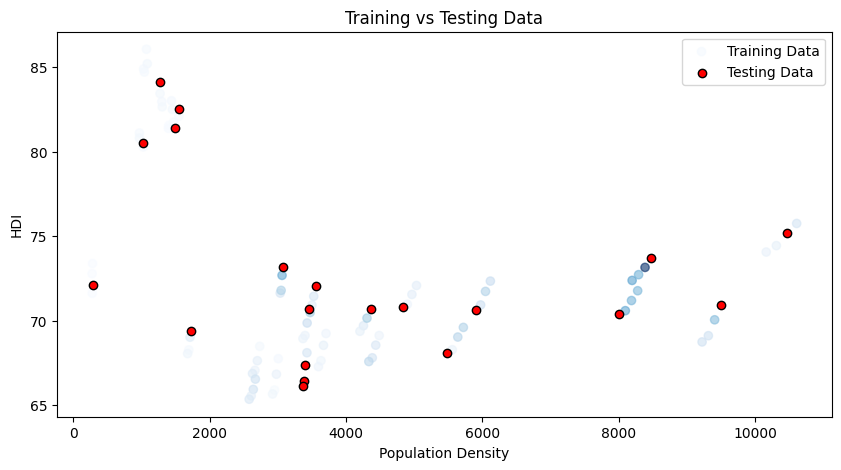

In [43]:
#To-do: plot training and testing data (One showing training points and another that shows testing points) with the prediction values
# Plot training and testing data
plt.figure(figsize=(10, 5))

# Scatter plot for Training Data
plt.scatter(X_train['Pop_den'], X_train['HDI'], c=y_train, cmap='Blues', label='Training Data', alpha=0.6)

# Scatter plot for Testing Data
plt.scatter(X_test['Pop_den'], X_test['HDI'], c='red', label='Testing Data', edgecolors='k')

plt.xlabel('Population Density')
plt.ylabel('HDI')
plt.legend()
plt.title('Training vs Testing Data')
plt.show()

In [53]:
# Create new dataset with NaN for testing 'Cases'
df_modified = df.copy()
df_modified.loc[test_index, 'Cases'] = np.nan  # Replace testing 'Cases' with NaN

# Save the dataset
df_modified.to_csv('../data/processed/df_aggVAE_rf_training_comparison.csv', index=False)

df_pointer = df.copy()
df_pointer["split"] = "train"
df_pointer.loc[test_index, 'split'] = 'test'

df_pointer.to_csv('../data/processed/df_aggVAE_rf_split.csv', index=False)

In [45]:
#in VAE: give counts of the training points in the random forest --> during VAE inference also pass the values of the district case counts
#in vae prevalence model: u provide data for the districts in which rf is being trained on. 

In [46]:
#OOB error to find the optimal n_estimators, with 500, 1000 trees; (dont need to tune max_features first)
# Define your random forest regressor
rf = RandomForestRegressor(oob_score=True, random_state=42)

# Set up the grid search parameters for n_estimators
param_grid = {
    'n_estimators': [100, 200, 500, 1000],  # Adjust as needed
}

# Set up GridSearchCV with oob_score
grid_search = GridSearchCV(rf, param_grid, cv=None, n_jobs=-1, scoring='neg_mean_squared_error')

# Fit the grid search
grid_search.fit(X_train, y_train)

# Get the best number of trees (n_estimators)
best_n_estimators = grid_search.best_params_['n_estimators']
print(f"Optimal n_estimators: {best_n_estimators}")

# Access the best OOB score
best_oob_score = grid_search.best_estimator_.oob_score_
print(f"Best OOB score: {best_oob_score}")

Optimal n_estimators: 1000
Best OOB score: 0.6518537559010162


In [47]:
#compute the predictions and then append the predictions to the df, then extract the df out
rf = RandomForestRegressor(n_estimators=1000, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [48]:
# Add the predictions to the test set (preserving indices)
X_test['Predicted_Cases'] = y_pred

# Now merge predictions back to the original dataframe using the indices of X_test
df_with_predictions = pd.merge(df, X_test[['Predicted_Cases']],
                                left_index=True, right_index=True, how='left')

# Show the dataframe with predictions included
print(df_with_predictions)

    District           x         y  Year  Area_sq_km    HDI   Province  Cases  \
0          0  107.610841 -7.099969  2020     1767.96  72.39  West Java   9180   
1          0  107.610841 -7.099969  2021     1767.96  72.73  West Java   8008   
2          0  107.610841 -7.099969  2022     1767.96  73.16  West Java  16764   
3          0  107.610841 -7.099969  2023     1767.96  73.74  West Java   4020   
4          1  107.414953 -6.897056  2020     1305.77  68.08  West Java   3864   
..       ...         ...       ...   ...         ...    ...        ...    ...   
91        22  107.980850 -6.825066  2023     1518.33  73.18  West Java   5232   
92        23  108.141296 -7.496706  2020     2551.19  65.67  West Java    716   
93        23  108.141296 -7.496706  2021     2551.19  65.90  West Java    188   
94        23  108.141296 -7.496706  2022     2551.19  66.84  West Java   1276   
95        23  108.141296 -7.496706  2023     2551.19  67.76  West Java    352   

    Population      Pop_den

In [49]:
#save the df with predictions
df_with_predictions.to_csv("../data/processed/df_combined_with_predictions_rf_popden_hdi.csv")

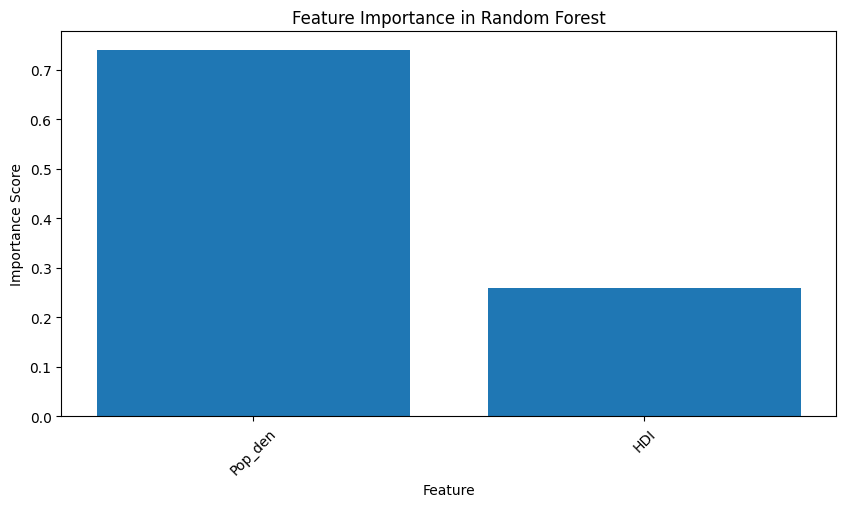

In [50]:
# Get feature importance
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]  # Sort in descending order

# Plot feature importance
plt.figure(figsize=(10, 5))
plt.title("Feature Importance in Random Forest")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=45)
plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.show()

In [52]:
# Save the model
with open("../model_weights/rf/random_forest_model_pop_den_hdi.pkl", "wb") as f:
    pickle.dump(rf, f)

# Load the model
#with open("random_forest_model.pkl", "rb") as f:
#    rf_loaded = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: '../../model_weights/rf/random_forest_model_pop_den_hdi.pkl'